In [1]:
import base64, collections, io, itertools, functools, json, os, random, re, textwrap, time, urllib
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot
import seaborn as sns
sns.set_style("white")
pyplot.style.use('default')

# Init

## Load Dataset

In [8]:
## Load data from Drive (Colab only).
data_path = '../data/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
def convert(line):
    """Converts single JSON line and converts 'drawing' to list of np.array."""
    d = json.loads(line)
    d['drawing'] = [np.array(stroke) for stroke in d['drawing']]
    return d
  
def loaditer(name, unrecognized=False, letter=False, scaled=False):
  """Returns iterable of drawings in specified file.

  Args:
    name: Name of the downloaded object (e.g. "elephant").
    unrecognized: Whether to include drawings that were not recognized
        by Google AI (i.e. the hard ones).
  """
  if(letter): 
    if(scaled):
      data_pathb = data_path+'/uji/'
    else:
      data_pathb = data_path+'/uji/no_scale/'
  else:
    data_pathb = data_path
  for line in tf.gfile.Open('%s/%s.ndjson' % (data_pathb, name)):
    d = convert(line)
    if unrecognized or d['recognized'] :
      yield d

def loadn(name, n, unrecognized=False, letter=False):
  """Returns list of drawings.

  Args:
    name: Name of the downloaded object (e.g. "elephant").
    n: Number of drawings to load.
    unrecognized: Whether to include drawings that were not recognized
        by Google AI (i.e. the hard ones).
  """
  it = loaditer(name, unrecognized=unrecognized, letter=letter)
  return list(itertools.islice(it, 0, n))

def loadALine(name,n,unrecognized=False,letter=False, scaled=False):
  count = 0
  if(letter): 
    if(scaled):
      data_pathb = data_path+'/uji/'
    else:
      data_pathb = data_path+'/uji/no_scale/'
  else:
    data_pathb = data_path
  for line in tf.gfile.Open('%s/%s.ndjson' % (data_pathb, name)):
    if(n == count):
      d = convert(line)
      if unrecognized or d['recognized'] :
          return d
    else:
      count +=1
      continue
  


In [6]:
import math

def findMinMax(letter): 
  xmin = min([row[0] for row in letter[0]])
  ymin = min([row[1] for row in letter[0]])
  xmax = max([row[0] for row in letter[0]])
  ymax = max([row[1] for row in letter[0]])
  for i in range(1,len(letter)): # for each stroke
    x = [row[0] for row in letter[i]]
    y = [row[1] for row in letter[i]]
    
    if min(x) < xmin : xmin = min(x) 
    if max(x) > xmax : xmax = max(x) 
    if min(y) < ymin : ymin = min(y) 
    if max(y) > ymax : ymax = max(y)
  return {'xmin':xmin,'xmax':xmax,'ymin':ymin,'ymax':ymax}
  

def rotate_around_point_highperf(xy, radians, origin=(0, 0)):
  """Rotate a point around a given point.

  I call this the "high performance" version since we're caching some$
  values that are needed >1 time. It's less readable than the previous
  function but it's faster.
  """
  x, y = xy
  offset_x, offset_y = origin
  adjusted_x = (x - offset_x)
  adjusted_y = (y - offset_y)
  cos_rad = math.cos(radians)
  sin_rad = math.sin(radians)
  qx = offset_x + cos_rad * adjusted_x + sin_rad * adjusted_y
  qy = offset_y + -sin_rad * adjusted_x + cos_rad * adjusted_y
  
  return [qx, qy]
  
def rotate_via_numpy(xy, radians):
  """Use numpy to build a rotation matrix and take the dot product."""
  x, y = xy
  c, s = np.cos(radians), np.sin(radians)
  j = np.matrix([[c, s, 0], [-s, c, 0], [0, 0, 1]])
  m = np.dot(j, [x, y, 1])

  return [float(m.T[0]), float(m.T[1])]

def rotate_path(stroke,radians):
  sx = stroke.T[0]
  sy = stroke.T[1]
  sq = np.array(stroke.T, dtype=float)
  for i in range(0, len(sx)):
    q = rotate_via_numpy((sx[i],sy[i]),radians)
    sq[0][i] = q[0]
    sq[1][i] = q[1]
  return sq.T

def rotate_letter(letter,radians):
  letterc = letter.copy()
  for i in range(0,len(letter)):
    q = rotate_path(letter[i],radians)
    letterc[i] = q
  return letterc


def stroke_cart2polar(stroke): 
  sx = stroke.T[0]
  sy = stroke.T[1]
  sq = np.array(stroke.T, dtype=float)
  for i in range(0, len(sx)):
    q = cart2polar(sx[i],sy[i])
    sq[0][i] = q[0]
    sq[1][i] = q[1]
  return sq.T


def letter_cart2polar(letter): 
  letterc = letter.copy()
  for i in range(0,len(letter)):
    q = stroke_cart2polar(letter[i])
    letterc[i] = q
  return letterc


def cart2polar(x, y):
  r = np.sqrt(x**2 + y**2)
  theta = np.arctan2(x, y)  # θ referenced to vertical
  return r, theta


def polar2cart(r, theta):
  y = r * np.cos(theta)   # θ referenced to vertical
  x = r * np.sin(theta)
  return x, y
  
  
def stroke_polar2cart(stroke): 
  sx = stroke.T[0]
  sy = stroke.T[1]
  sq =  np.array(stroke.T, dtype=float)
  for i in range(0, len(sx)):
    q = polar2cart(sx[i],sy[i])
    sq[0][i] = q[0]
    sq[1][i] = q[1]
  return sq.T


def letter_polar2cart(letter): 
  letterc = letter.copy()
  for i in range(0,len(letter)):
    q = stroke_polar2cart(letter[i])
    letterc[i] = q
  return letterc



def plotLetter(letter):
  for stroke in letter['drawing']:
    xy = stroke.T
    pyplot.plot(xy[0,:], -xy[1,:])
    pxy = xy[:]
    # Indicate "point captured" with a red circle.
    pyplot.plot(pxy[0], -pxy[1], 'bo');
    pyplot.plot(pxy[0,0], -pxy[1,0], 'r*')
    
    
def plotLetterScaled(letter):
  for stroke in letter['drawing']:
    xy = stroke.T
    pyplot.plot(xy[0,:], xy[1,:])
    pxy = xy[:]
    # Indicate "point captured" with a red circle.
    pyplot.plot(pxy[0], pxy[1], 'bo');
    pyplot.plot(pxy[0,0], pxy[1,0], 'r*')
  
  
def rescale(letter):
  scaled_letter = [] 
  minmax = findMinMax(letter)
  #print(minmax)
  for i in range(0,len(letter)): # for each stroke
    x = [row[0] for row in letter[i]]
    y = [row[1] for row in letter[i]]
    
    x = [(i - minmax['xmin'])/ (minmax['xmax']- minmax['xmin'])   for i in x]
    y = [(j - minmax['ymin'])/ (minmax['ymax']- minmax['ymin'])  for j in y]
    
    
    
    row = list(zip(x,y))
    scaled_letter.append(row)
  
  return scaled_letter


def rescaleLetter(letter):
  scaled_letter = letter.copy()
  minmax = findMinMax(letter)
  #print(minmax)
  for i in range(0,len(letter)): # for each stroke
    x = [row[0] for row in letter[i]]
    y = [row[1] for row in letter[i]]
    
    x = [(i - minmax['xmin'])/ (minmax['xmax']- minmax['xmin'])   for i in x]
    y = [(j - minmax['ymin'])/ (minmax['ymax']- minmax['ymin'])  for j in y]
    
    sq =  np.array(letter[i].T, dtype=float)
    sq[0] = x
    sq[1] = y
    
    scaled_letter[i] = sq.T
  
  return scaled_letter



def zstroke(stroke):
  sx = stroke.T[0]
  sy = stroke.T[1]
  sq = np.array(stroke.T, dtype=float)
  sq = stats.zscore(sq, axis=1)
  return sq.T

def zletter(letter):
  sx = stroke.T[0]
  sy = stroke.T[1]
  sq = np.array(stroke.T, dtype=float)
  sq = stats.zscore(sq, axis=1)
  return sq.T
  

<Figure size 432x288 with 0 Axes>

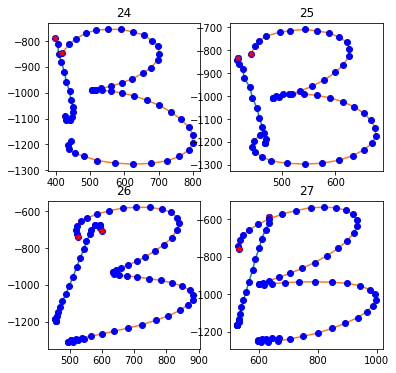

In [9]:
letterChar = 'B' #@param ["A", "a", "b", "B","C","c","L","l","O","o"] {allow-input: true}
minLet = 24 #@param {type:"slider", min:0, max:119, step:1}
nb = 2 #@param {type:"slider", min:2, max:10, step:1}

# Some more letters...
rows, cols = nb, 2

# Some more letters...
pyplot.figure(3)
pyplot.figure(figsize=(3*cols, 3*rows))
for y in range(rows):
  for x in range(cols):
    i = y * cols + x 
    pyplot.subplot(rows, cols, i + 1)
    pyplot.title(minLet+i)
    letter_sample = loadALine(letterChar,minLet+i, letter=True, unrecognized=True)
    plotLetter(letter_sample)
    #for s in letter_sample['drawing']:
    #  pyplot.plot(s.T[0], -s.T[1])


  
nice_l = {'B':28, 'A':21,'a':69,'b':61, 'C':37, 'c':89,'L':34, 'l':32, 'O':32, 'o':56}
#b 71, b 46

#  Preprocessing

done at the letter level

noramize and translate to 128

8 unit between 2 points in resampling

In [10]:
from matplotlib.patches import Rectangle
from sklearn import preprocessing
from scipy.interpolate import splprep
from scipy.signal import resample


def boxCenter(box):
  return ((box['xmax']-box['xmin'])/2, (box['ymax']-box['ymin'])/2)
  

def getBondingBox(letter):
  '''
  returns centroid, w and l and top left corner 
  
  '''
  
  minmax = findMinMax(letter['drawing'])
  centroid = boxCenter(minmax)
  size = (minmax['xmax'] - minmax['xmin'] , minmax['ymax'] - minmax['ymin'] )
  
  
  return (centroid, size, ( minmax['xmin'] , minmax['ymin'] ))


def drawBox(x,y,w,l):
  # Create a Rectangle patch
  rect = Rectangle((x,y),w,l,linewidth=1,edgecolor='r',facecolor='none')

  # Get the current reference
  ax = pyplot.gca()

  # Add the patch to the Axes
  ax.add_patch(rect)


def linearScaling(letter, dim=128):
  scaled_letter = letter.copy()
  minmax = findMinMax(letter['drawing'])
  for i in range(0,len(letter['drawing'])): # for each stroke
    x = [row[0] for row in letter['drawing'][i]]
    y = [row[1] for row in letter['drawing'][i]]
    
    x = [(i - minmax['xmin'])/ (minmax['xmax']- minmax['xmin'])   for i in x]
    y = [(j - minmax['ymin'])/ (minmax['ymax']- minmax['ymin'])  for j in y]
    y = [j * -1 for j in y]
    
    sq =  np.array(letter['drawing'][i].T, dtype=float)
    
    sq[0] = x
    sq[1] = y 
    
    scaled_letter['drawing'][i] = sq.T *dim
  
  return scaled_letter


'''def resampleLetter(letter,eq=8):
  scaled_letter = letter.copy()
  
  for i in range(0,len(letter['drawing'])): # for each stroke
    sq =  np.array(letter['drawing'][i], dtype=float)
    x = [row[0] for row in sq]
    y = [row[1] for row in sq]
    print(len(x))
    x =  resample(x, eq)
    y =  resample(y, eq)
    print(len(x))
    
    sq[0] = x
    sq[1] = y 
    
    
    scaled_letter['drawing'][i] = sq
  
  return scaled_letter
'''
  

def translation():
  '''
  Centers the drawing in a w,h size
  '''
  
  return
  

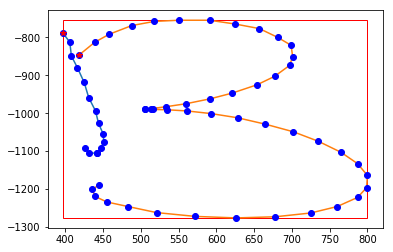

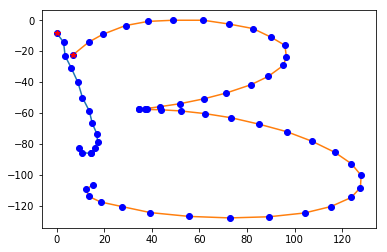

In [11]:
letterChar = 'B' #@param ["A", "a", "b", "B","C","c","L","l","O","o"] {allow-input: true}
minLet = 24 #@param {type:"slider", min:0, max:119, step:1}



letter_sample = loadALine(letterChar,minLet, letter=True, unrecognized=True)

centroid, size, ori = getBondingBox(letter_sample)
w,l = size
xm, ym = ori
drawBox(xm,-ym,w,-l)

plotLetter(letter_sample)

pyplot.figure(3)
scaled = linearScaling(letter_sample)
plotLetterScaled(scaled)

  
  

# HBF49 Features

## Dynamic Features for each stroke

- starting point position (f1, f2)
- ending point position (f3, f4)
- first to last point vector v 

In [12]:
def f1(stroke, centroid, dim):
  return (stroke[0,0] - centroid[0])/dim +1/2 

def f2(stroke, centroid, dim):
  return (stroke[0,1] - centroid[1])/dim +1/2 

def f3(stroke, centroid, dim):
  return (stroke[-1,0] - centroid[0])/dim +1/2 

def f4(stroke, centroid, dim):
  return (stroke[-1,1] - centroid[1])/dim +1/2 


In [13]:
from numpy import linalg as LA
from scipy.spatial import distance

def getVEndStart(stroke):
  return np.array([stroke[-1,0] - stroke[0,0], stroke[-1,1] - stroke[0,1]])

def f5(vendstart):
  return LA.norm(vendstart)

def f6(vendstart):
  ux = np.array([1,0])
  nv  =  vendstart / LA.norm(vendstart)
  a = np.dot(nv,ux)
  print(a)
  return np.cos(a)

def f7(vendstart):
  uy = np.array([0,1])
  nv  =  vendstart / LA.norm(vendstart)
  a = np.dot(nv,uy)
  print(a)
  return np.sin(a)

In [14]:
from math import hypot

def getLengthPath(stroke):
  lengths = np.sqrt(np.sum(np.diff(stroke, axis=0)**2, axis=1)) # Length between corners
  total_length = np.sum(lengths)
  return total_length

def getLengthLetter(letter):
  lengths = [getLengthPath(s) for s in letter['drawing']]
  total_length = np.sum(lengths)
  return total_length

def f8(vendstart,l):
  return f5(vendstart)/l

In [15]:
s = letter_sample['drawing'][1]
v = getVEndStart(s)
l = getLengthPath(s)
ll = getLengthLetter(letter_sample)

f8(v, l)
print(l)

430.67425430003266


In [16]:
def getInitialVect(stroke): ## consider vect between first and third point
  return np.array([stroke[2,0] - stroke[0,0], stroke[2,1] - stroke[0,1]])

def f9(initVect):
  return f6(initVect)

def f10(initVect):
  return f7(initVect)
  

In [17]:
def getMiddlePoint(stroke):
  m = int(len(stroke)/2)
  return stroke[m]

def f11(stroke, m, dim):
  return 1/w * (m[0] - (stroke[0,0] + stroke[-1,0])/2)

def f12(stroke, m, dim):
  return 1/w * (m[1] - (stroke[0,1] + stroke[-1,1])/2)

m = getMiddlePoint(s)
f12(s,m,128)

0.01615522734958063

In [18]:
import math

def f14(letter):
  return letter['nb_stroke']

f14(letter_sample)


centroid, size, ori = getBondingBox(letter_sample)
w,l = size
xm, ym = ori

## Visual Features

In [19]:

def f15(size):
  w,h = size
  return math.atan(h/w)

def f16(letter):
  return getLengthLetter(letter)

def f17(l_length, size):
  w,h = size
  return (w+h)/l_length
  
def centroidLetter(letter):
  centroids = [ centroidStroke(stroke) for stroke in letter['drawing']]  
  return np.average(centroids, axis=0)

def centroidStroke(arr):
  sum_x = np.sum(arr[:, 0])
  sum_y = np.sum(arr[:, 1])
  return [sum_x/len(arr), sum_y/len(arr)]

def f18(stroke, centroid):
  deviations = [np.abs(si - centroid) for si in stroke]
  print(deviations)
  return np.average(deviations, axis=0)


In [20]:
centroidd = centroidLetter(letter_sample)
centroidd

array([ 37.8842162 , -60.84246015])

In [21]:
def f19(stroke): 
  directions = [np.arctan((stroke[i+1][1]- stroke[i][1])/stroke[i+1][0]- stroke[i][0]) for i in range(len(stroke)-1)]
  return np.average(directions, axis=0)
  

In [24]:
import math

def dotproduct(v1, v2):
  return sum((a*b) for a, b in zip(v1, v2))

def length(v):
  return math.sqrt(dotproduct(v, v))

def arccos(v1, v2):
  return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))

def thetaI(stroke, i):
  return arccos(stroke[i] - stroke[i-1], stroke[i+1] -stroke[i])


def f20(stroke):
  curvatures = [thetaI(stroke, i) for i in range(2, len(stroke)-1)]
  filt = filter(lambda v: v==v, curvatures) ## filter out the nan values
  curvatures = [x for x in filt]
  return np.sum(curvatures)

def f21(stroke):
  curvatures = [math.pow(math.sin(thetaI(stroke, i)),2) for i in range(2, len(stroke)-1)]
  filt = filter(lambda v: v==v, curvatures) ## filter out the nan values
  curvatures = [x for x in filt]
  return np.sum(curvatures)

def thetaIk(stroke, i, k):
  return arccos(stroke[i] - stroke[i-k], stroke[i+k] -stroke[i])

def f22(stroke, k):
  curvatures = [math.pow(math.sin(thetaIk(stroke, i, k)),2) for i in range(2, len(stroke)-1)]
  filt = filter(lambda v: v==v, curvatures) ## filter out the nan values
  curvatures = [x for x in filt]
  return np.sum(curvatures)

def f23(stroke, k):
  curvatures = [thetaIk(stroke, i, k) for i in range(2, len(stroke)-1)]
  filt = filter(lambda v: v==v, curvatures) ## filter out the nan values
  curvatures = [x for x in filt]
  return np.max(curvatures)



In [25]:
def segmentOrientation(stroke, i):
  si =  stroke[i+1] -stroke[i]
  ux = [length(si), 0]
  return arccos(si, ux)

segmentOrientation(s,8)

def segmentOrientationList(stroke):
  segtO = [segmentOrientation(stroke, i) for i in range(len(stroke) -1)]
  return segtO
  
lh = segmentOrientationList(s)
np.histogram(lh, bins=8)

/home/wafa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/home/wafa/.local/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/home/wafa/.local/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


ValueError: autodetected range of [nan, nan] is not finite

In [ ]:
(10.608436724565758 + 65.15999568453985)/2

37.88421620455281

In [ ]:
  #
  #print(curvatures)